In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 

In [2]:
df = pd.read_csv("saas.csv", parse_dates=['Month_Invoiced'], index_col='Month_Invoiced', usecols=['Month_Invoiced', 'Subscription_Type', 'Amount']).sort_index()

In [3]:
df.head()

,Subscription_Type,Amount
Month_Invoiced,,
2014-01-31,0.0,0.0
2014-01-31,2.0,10.0
2014-01-31,0.0,0.0
2014-01-31,0.0,0.0
2014-01-31,1.0,5.0


In [4]:
print('Number of rows:', df.index.nunique())
n_days = df.index.max() - df.index.min() + pd.Timedelta('1d')
print(f"Number of days between first and last day:", n_days)

Number of rows: 48
Number of days between first and last day: 1431 days 00:00:00


In [5]:
df.index.min()

Timestamp('2014-01-31 00:00:00')

In [6]:
df.index.value_counts()

2014-01-31    20000
2014-02-28    19800
2014-03-31    19599
2014-04-30    19413
2014-05-31    19221
2014-06-30    19038
2014-07-31    18851
2014-08-31    18672
2014-09-30    18494
2014-10-31    18313
2014-11-30    18145
2014-12-31    17996
2015-01-31    17829
2015-02-28    17680
2015-03-31    17530
2015-04-30    17376
2015-05-31    17225
2015-06-30    17089
2015-07-31    16951
2015-08-31    16817
2015-09-30    16671
2015-10-31    16529
2015-11-30    16387
2015-12-31    16268
2016-01-31    16142
2016-02-29    16019
2016-03-31    15895
2016-04-30    15777
2016-05-31    15685
2016-06-30    15571
2016-07-31    15460
2016-08-31    15355
2016-09-30    15240
2016-10-31    15144
2016-11-30    15049
2016-12-31    14938
2017-01-31    14840
2017-02-28    14741
2017-03-31    14665
2017-04-30    14576
2017-05-31    14475
2017-06-30    14400
2017-07-31    14312
2017-08-31    14209
2017-09-30    14131
2017-10-31    14041
2017-11-30    13985
2017-12-31    13914
Name: Month_Invoiced, dtype: int64

In [7]:
#df.Subscription_Type.value_counts()

In [8]:
df.Amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: Amount, dtype: int64

In [9]:
df.isna().sum()

Subscription_Type    0
Amount               0
dtype: int64

In [10]:
df = df.resample('M').sum()

In [11]:
train_index = int(len(df) * 0.6)

In [12]:
val_index = int(len(df) * 0.85)

In [13]:
train = df[:train_index]

In [14]:
train.shape

(28, 2)

In [15]:
val = df[train_index:val_index]

In [16]:
val.shape

(12, 2)

In [17]:
test = df[val_index:]

In [18]:
test.shape

(8, 2)

In [19]:
df.shape[0] == train.shape[0] + val.shape[0] + test.shape[0]

True

2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend 
    - Holt's Seasonal Trend
    - Based on previous year/month/etc., this is up to you.

### Last Observed Value

In [20]:
#train['Subscription_Type'][-1:][0]

In [21]:
#len(train[train['Subscription_Type'] == 0.0])

In [22]:
#len(train[train['Subscription_Type'] != 0.0])

In [23]:
#len(train.Customer_Id.value_counts())

In [24]:
#len(train.Invoice_Id.value_counts())

In [25]:
#last_subscription = train['Subscription_Type'].tail(1)

In [26]:
last_amount = train['Amount'].tail(1)

In [27]:
yhat_df = pd.DataFrame(
    {'amount': last_amount},
    index=val.index)

#rmse0 = round(sqrt(mean_squared_error(val['Amount'], yhat_df['Amount'])), 0)

rmse1 = round(sqrt(mean_squared_error(val['Amount'], yhat_df['amount'])), 0)

Basically the prediction is 0.0 for Subscription Type and Amount.

### Simple Average

In [28]:
avg_amount = round(train['Amount'].mean(), 2)
avg_amount

46490.89

In [29]:
def make_baseline_predictions(sales_predictions=None, quantity_predictions=None):
    yhat_df = pd.DataFrame({'Amount': avg_amount},
                          index=val.index)
    return yhat_df

In [30]:
yhat_df = make_baseline_predictions(avg_amount)

In [31]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-05-31,46490.89
2016-06-30,46490.89
2016-07-31,46490.89
2016-08-31,46490.89
2016-09-30,46490.89


In [32]:
rmse1 = round(sqrt(mean_squared_error(val['Amount'], yhat_df['Amount'])), 0)
rmse1

6597.0

### Moving Average

In [33]:
period = 30

In [34]:
#Keeping the last 30 days
rolling_amount = round(train['Amount'].rolling(period).mean()[-1],2)
print(rolling_amount)

nan


In [35]:
yhat_df = make_baseline_predictions(rolling_amount)

In [36]:
yhat_df.head()

,Amount
Month_Invoiced,
2016-05-31,46490.89
2016-06-30,46490.89
2016-07-31,46490.89
2016-08-31,46490.89
2016-09-30,46490.89


Amount -- RMSE: 6597


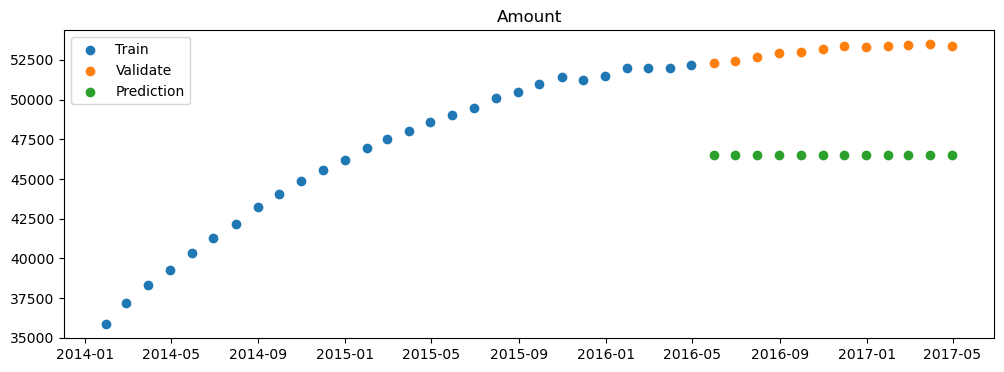

In [37]:
plt.figure(figsize = (12,4))
plt.scatter(x = train.index, y=train['Amount'], label = 'Train')
plt.scatter(x= val.index, y=val['Amount'], label = 'Validate')
plt.scatter(x= val.index, y = yhat_df['Amount'], label = 'Prediction')
plt.title('Amount')
rmse = round(sqrt(mean_squared_error(val['Amount'], yhat_df['Amount'])), 0)

print('Amount', '-- RMSE: {:.0f}'.format(rmse))
plt.legend()
plt.show()

### Holt Linear

In [38]:
col = 'Amount' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [39]:
# fit the Holt object
model = model.fit(optimized=True)

In [40]:
start = val.index[0]

In [41]:
end = val.index[-1]

In [42]:
yhat_amount_total = model.predict(start =start, end = end)

Amount -- RMSE: 351


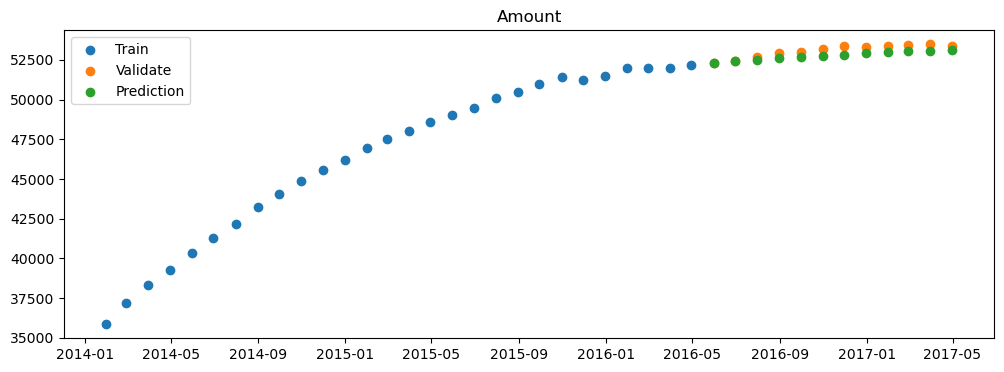

In [43]:
plt.figure(figsize = (12,4))
plt.scatter(x = train.index, y=train['Amount'], label = 'Train')
plt.scatter(x= val.index, y=val['Amount'], label = 'Validate')
plt.scatter(x= val.index, y = yhat_amount_total, label = 'Prediction')
plt.title('Amount')
rmse = round(sqrt(mean_squared_error(val['Amount'], yhat_amount_total)), 0)
plt.legend()
print('Amount', '-- RMSE: {:.0f}'.format(rmse))
plt.show()

### Holt's Seasonal Trend

In [44]:
hst_amount_fit1 = ExponentialSmoothing(train.Amount, seasonal_periods=12, trend='add', seasonal='add').fit()
hst_amount_fit2 = ExponentialSmoothing(train.Amount, seasonal_periods=12, trend='add', seasonal='mul').fit()
hst_amount_fit3 = ExponentialSmoothing(train.Amount, seasonal_periods=12, trend='add', seasonal='add', damped=True).fit()
hst_amount_fit4 = ExponentialSmoothing(train.Amount, seasonal_periods=12, trend='add', seasonal='mul', damped=True).fit()

/Users/joshholt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/joshholt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/joshholt/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [45]:
results_amount=pd.DataFrame({'model':['hst_amount_fit1', 'hst_amount_fit2', 'hst_amount_fit3', 'hst_amount_fit4'],
                              'SSE':[hst_amount_fit1.sse, hst_amount_fit2.sse, hst_amount_fit3.sse, hst_amount_fit4.sse]})
results_amount

,model,SSE
0,hst_amount_fit1,8.232845e+06
1,hst_amount_fit2,4.464662e+07
2,hst_amount_fit3,4.401569e+07
3,hst_amount_fit4,4.378357e+07


In [46]:
yhat_df = pd.DataFrame({'Amount': hst_amount_fit1.forecast(val.shape[0])}, index=val.index)
yhat_df

,Amount
Month_Invoiced,
2016-05-31,53184.294297
2016-06-30,53706.382984
2016-07-31,54276.253414
2016-08-31,54768.912661
2016-09-30,55222.086548
2016-10-31,55598.350827
2016-11-30,55551.486450
2016-12-31,55717.351095
2017-01-31,55660.581319


Amount -- RMSE: 2384


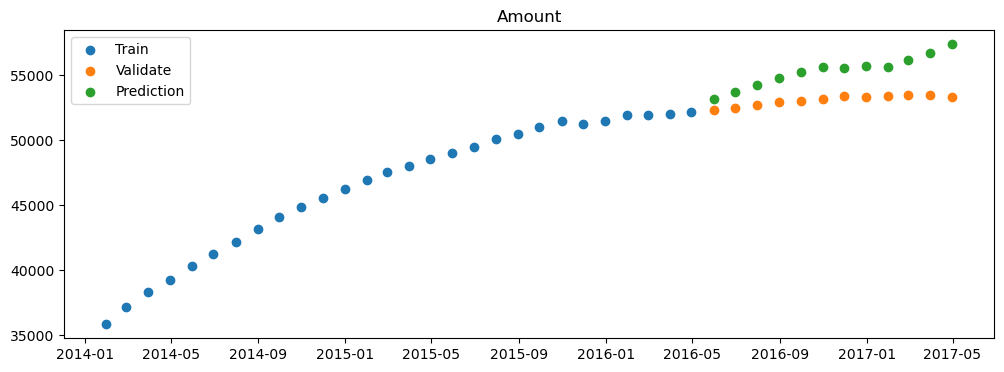

In [47]:
plt.figure(figsize = (12,4))
plt.scatter(x = train.index, y=train['Amount'], label = 'Train')
plt.scatter(x= val.index, y=val['Amount'], label = 'Validate')
plt.scatter(x= val.index, y = yhat_df, label = 'Prediction')
plt.title('Amount')
rmse = round(sqrt(mean_squared_error(val['Amount'], yhat_df)), 0)
plt.legend()
print('Amount', '-- RMSE: {:.0f}'.format(rmse))
plt.show()

Bonus: 
1. Using the store item demand data, create a forecast of `sales_total` and `quantity` for 2018 using the `Previous Cycle` approach.  .  
2. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
4. Plot the 2018 monthly sales predictions.